## Time Series Forecasting
Time Series Forecasting involves utilizing past historical data to predict future values at future time periods. There are many methods that can be used for forecasting, in statistical or machine learning models.

Since our data is affected by seasonality, where there are different outputs depending on specific periods of time, we will implement data pipelines which utilize models that address seasonality. For our statistical approach, we will be using VAR(Vector Model Regression) model for our multivariate data which will capture underlying patterns and trends, and for our machine learning approach we will be utilizing Facebook's PROPHET library, which captures non-linear complex relationships within data and between features well as well as be able to handle missing values.

Our data are daily sales in Ecuardorian markets from Kaggle.
 

In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 

In [26]:
sale_df = pd.read_csv(r"C:\Users\cecil\OneDrive\Desktop\Projects\data\timesales_train.csv") 
# For prediction: 15 days after the last date in the training data.
sale_df_test = pd.read_csv(r"C:\Users\cecil\OneDrive\Desktop\Projects\data\timesales_test.csv")


sale_df
##Check date ranges of datasets
#min(sale_df['date']), max(sale_df['date'])
# min(sale_df_test['date']), max(sale_df_test['date'])
#use past historical date train to compare as 'validation', then final model forecast

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [27]:
print(f'{sale_df.dtypes}\n')
#Number of Nulls in each column
print(f'{sale_df.isna().sum()}\n')
#Rows of data
print(sale_df.shape)

# sale_df['family'].unique().sum()

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

(3000888, 6)


#### Preprocessing Data

In [28]:
#Change date into datetime datatype
sale_df['date'] = pd.to_datetime(sale_df.date)

#Change product family into string
def fam_to_str(family):
    return str(family).replace('\n1', '')

sale_df['family'] = sale_df['family'].apply(fam_to_str)

#Deal With Missing Data
not_sold = len(sale_df.loc[sale_df['sales'].isna()])/len(sale_df) * 100

print(f'The proportion of missing data is: {round(not_sold,2)} %')
sale_df = sale_df.loc[sale_df['sales'].notna()]

num_cat = len(sale_df['family'].unique().tolist())
print(f'The number of categories is: {num_cat}')

The proportion of missing data is: 0.0 %
The number of categories is: 33


We would like to explore our initial data to see if the data is sufficient for forecasting. We would like sales at least in the thousands on a daily basis, as we needhigh-volume metrics to ensure reliabiity and reduce noise. We will visualize the total sales grouped by family (product category) in daily-level

In [29]:
"""
Visualize Total Sales Revenue of each Product
"""
prod_total_sale = sale_df.groupby(by = ['date', 'family']).agg({'sales': 'sum'}).reset_index().sort_values(by = ['date', 'family'])
prod_total_sale

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.000000
1,2013-01-01,BABY CARE,0.000000
2,2013-01-01,BEAUTY,2.000000
3,2013-01-01,BEVERAGES,810.000000
4,2013-01-01,BOOKS,0.000000
...,...,...,...
55567,2017-08-15,POULTRY,17586.709986
55568,2017-08-15,PREPARED FOODS,4641.522980
55569,2017-08-15,PRODUCE,125108.971000
55570,2017-08-15,SCHOOL AND OFFICE SUPPLIES,2530.000000


In [30]:
""""
Visualizing Total Sales Revenue for each product
"""
#Pivoting dataframe to have family as column
prod_sales = prod_total_sale.pivot(index="date", columns="family", values="sales")
prod_sales.head(2)

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.0,0.0,2.0,810.0,0.0,180.589,0.0,186.0,143.0,71.09,...,0.0,110.801000,25.0,0.0,0.0,42.637000,37.847000,0.0,0.0,0.000000
2013-01-02,255.0,0.0,207.0,72092.0,0.0,26246.319,0.0,74629.0,23381.0,15754.50,...,0.0,20871.464028,17204.0,0.0,0.0,13975.884938,5338.111976,0.0,0.0,1526.750002


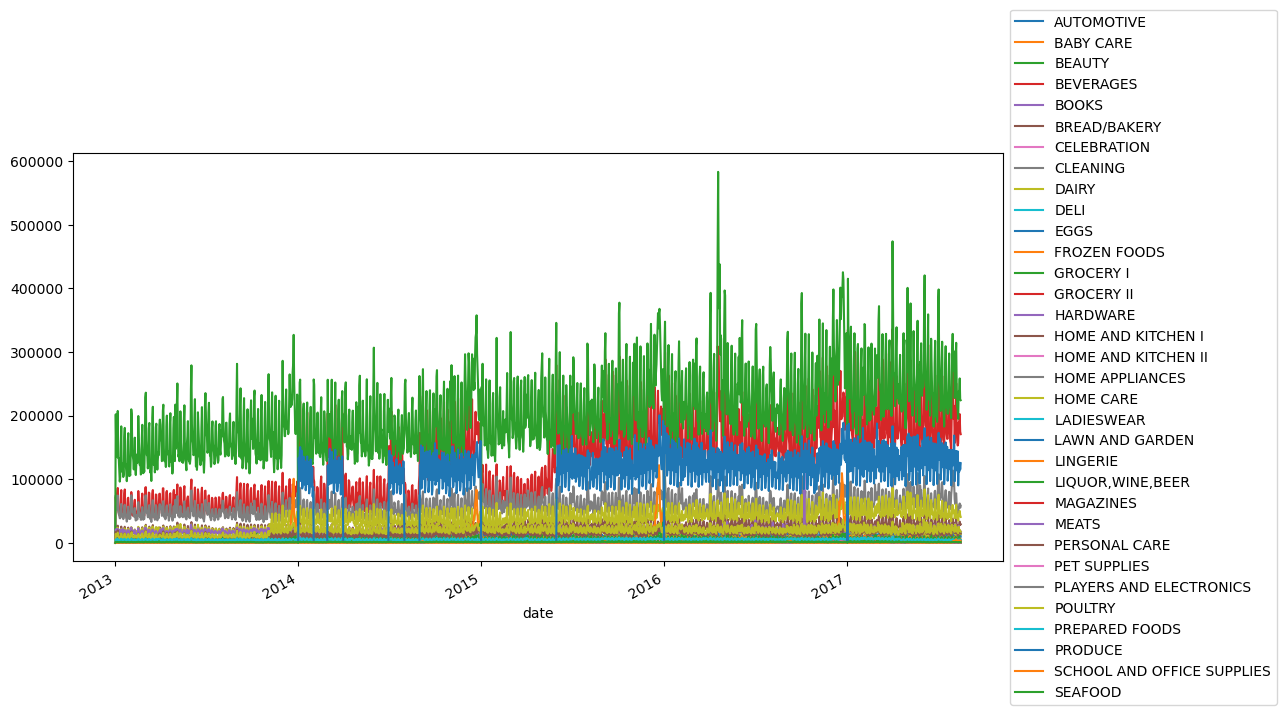

In [31]:
#Overlaid categories
prod_sales.plot()

plt.gcf().set_size_inches(12, 6)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

C:\Users\cecil\AppData\Local\Temp\ipykernel_25164\2113559898.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 1000x500 with 0 Axes>

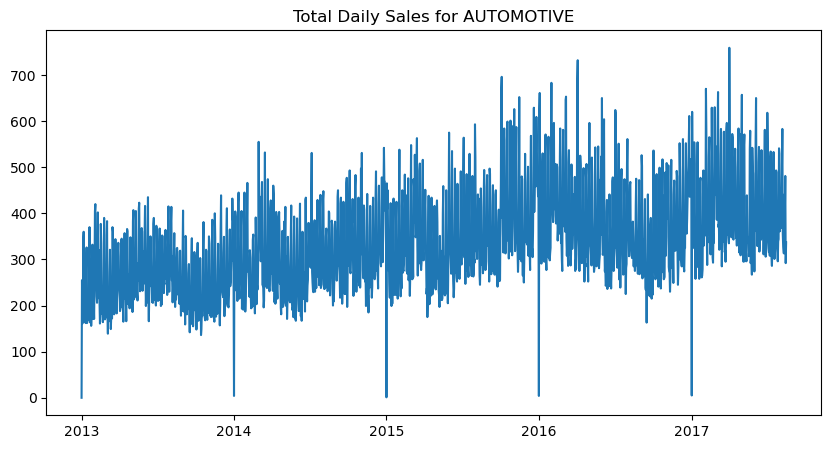

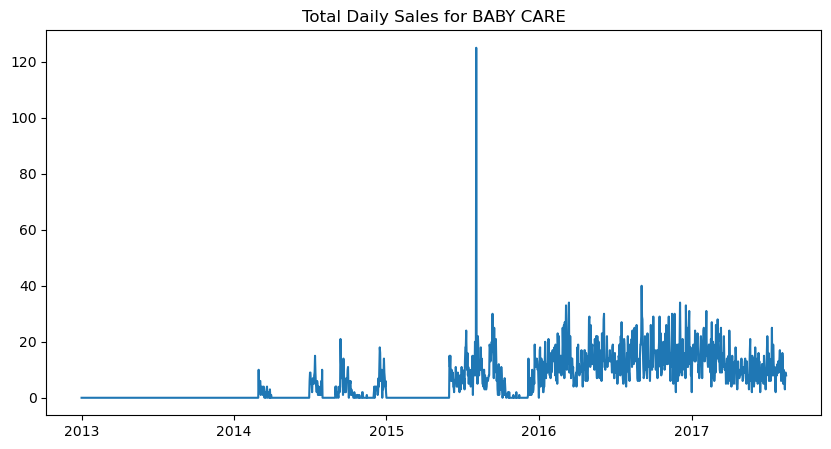

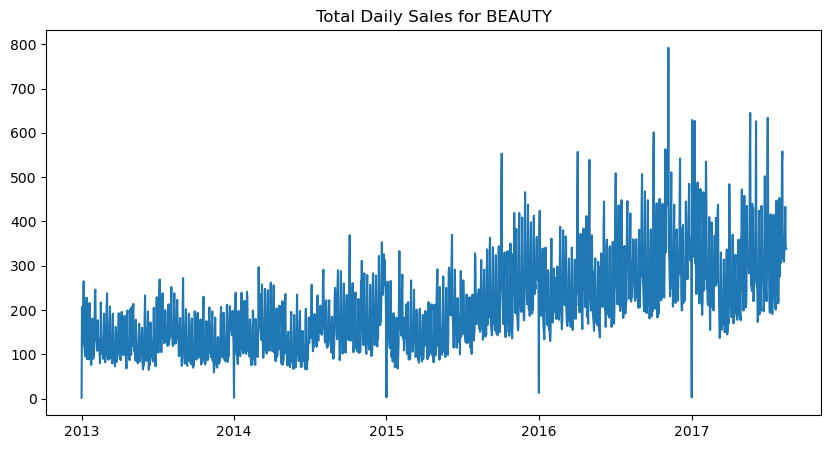

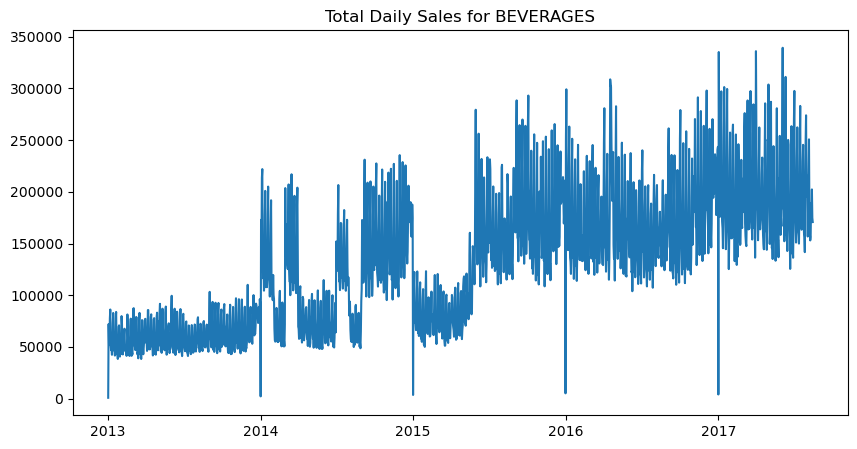

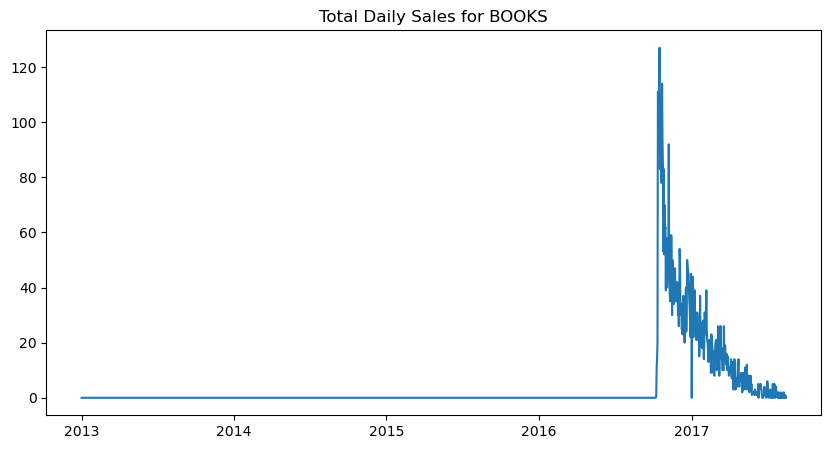

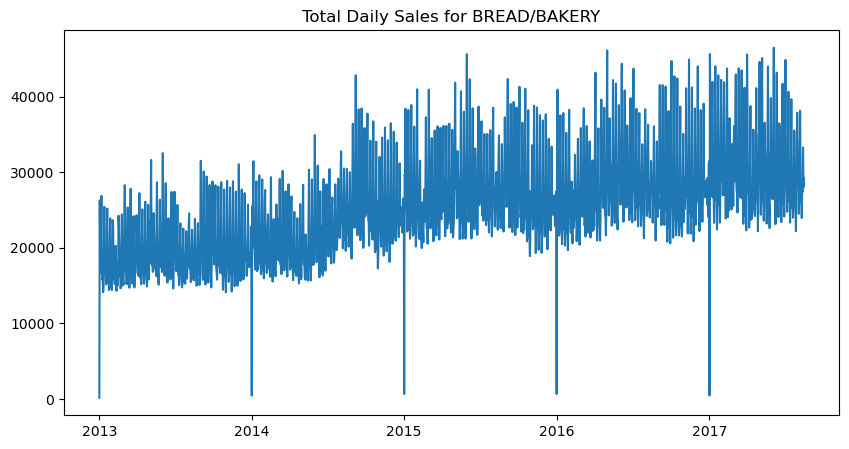

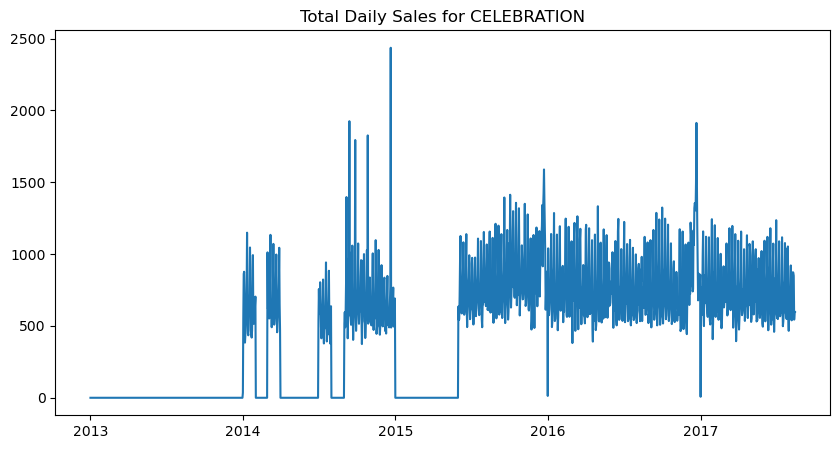

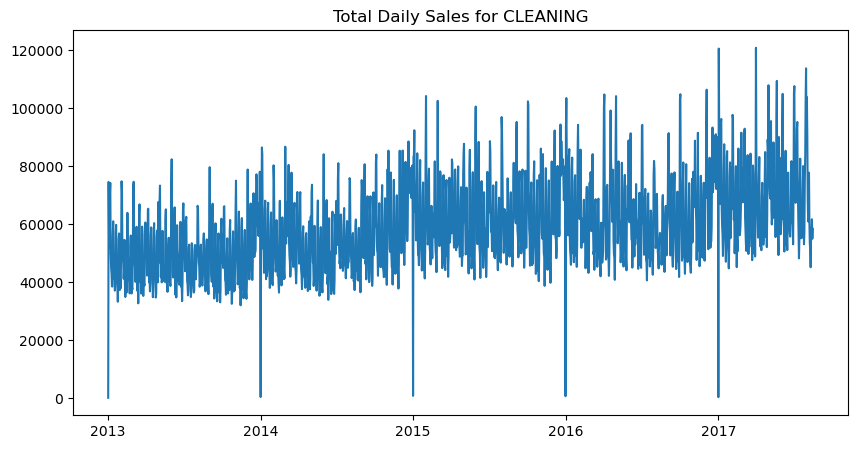

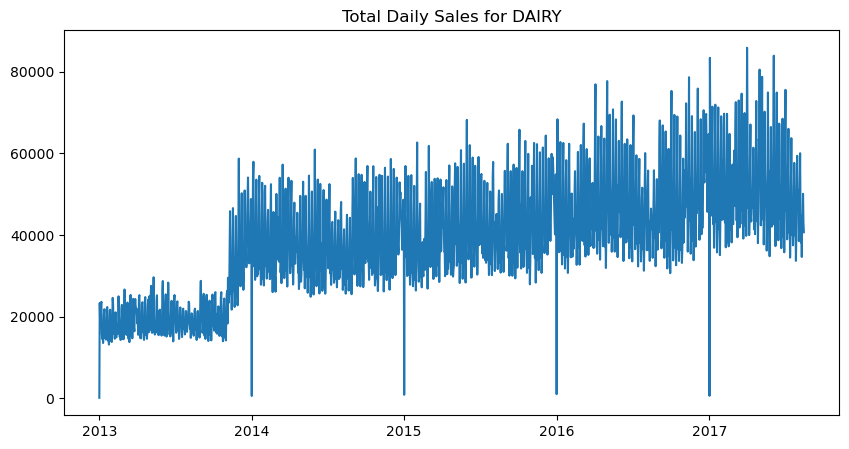

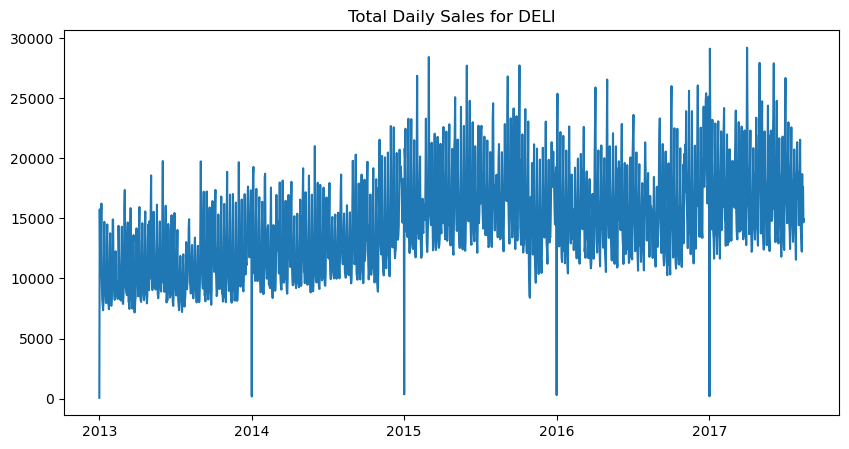

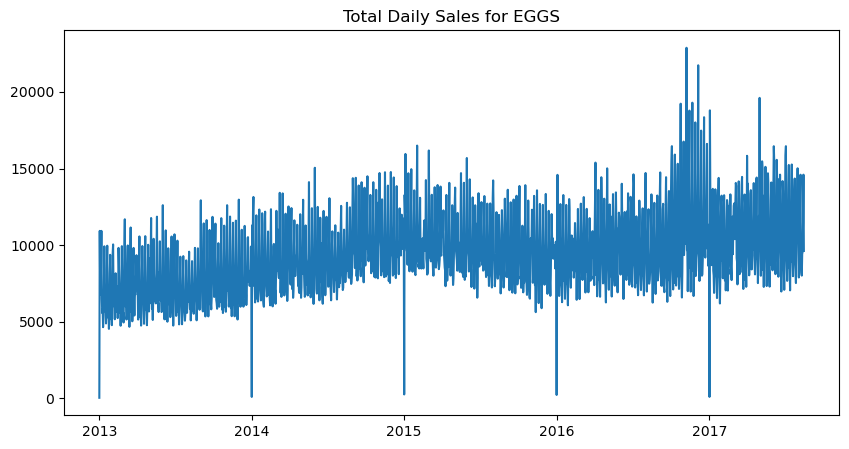

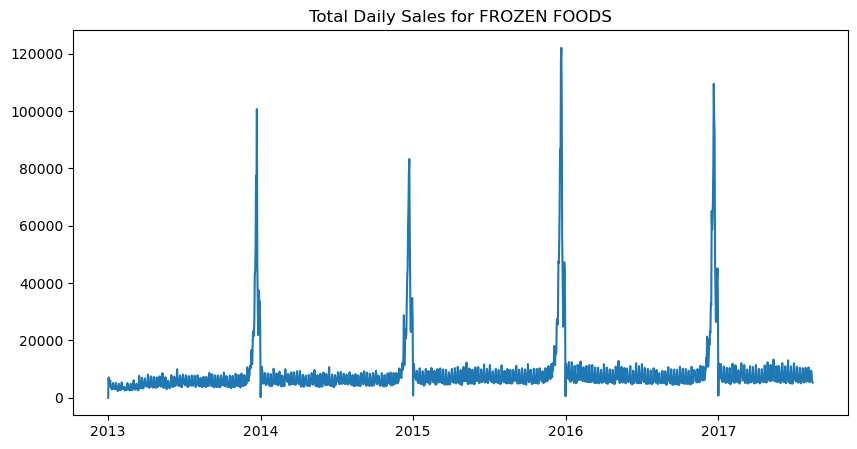

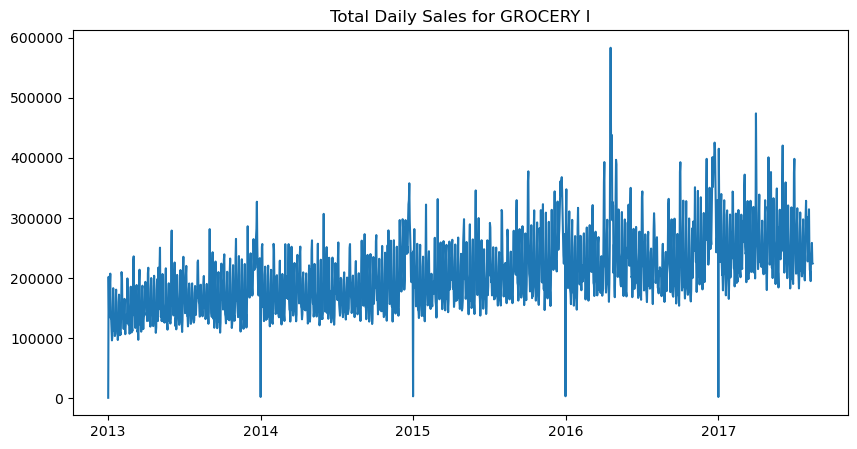

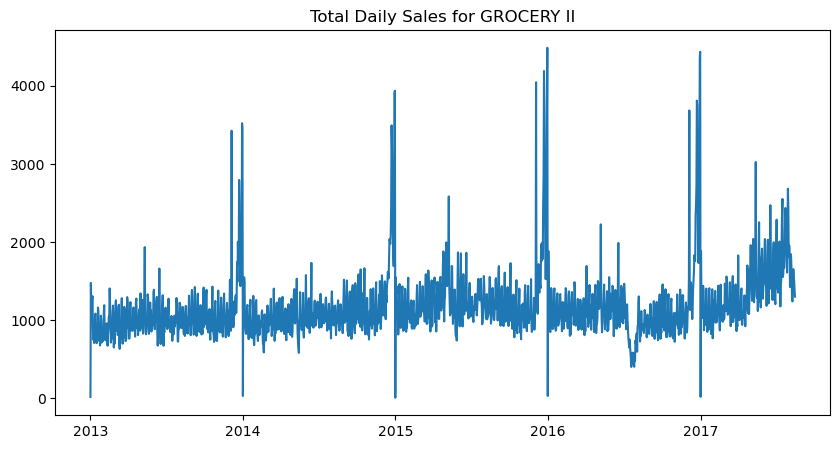

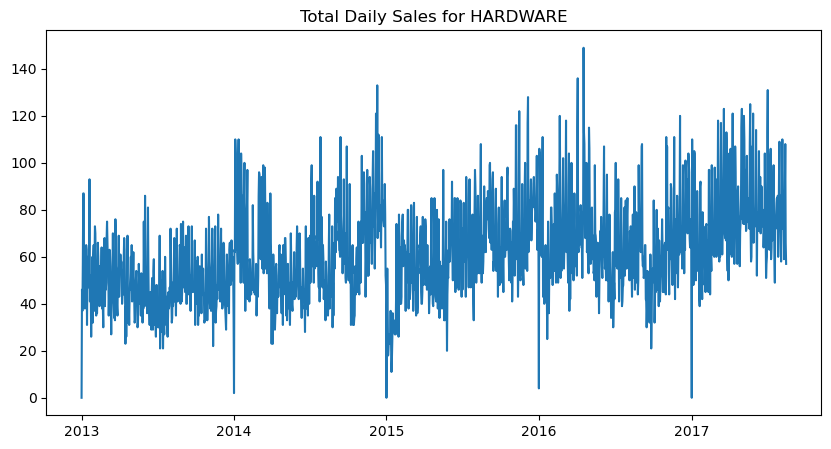

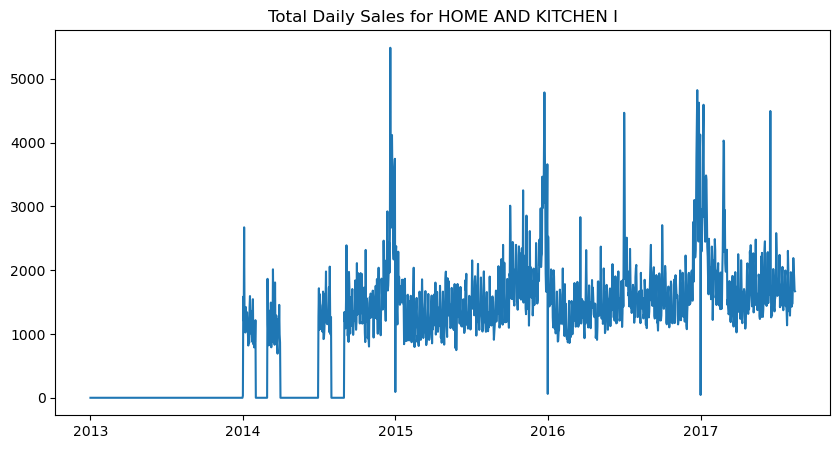

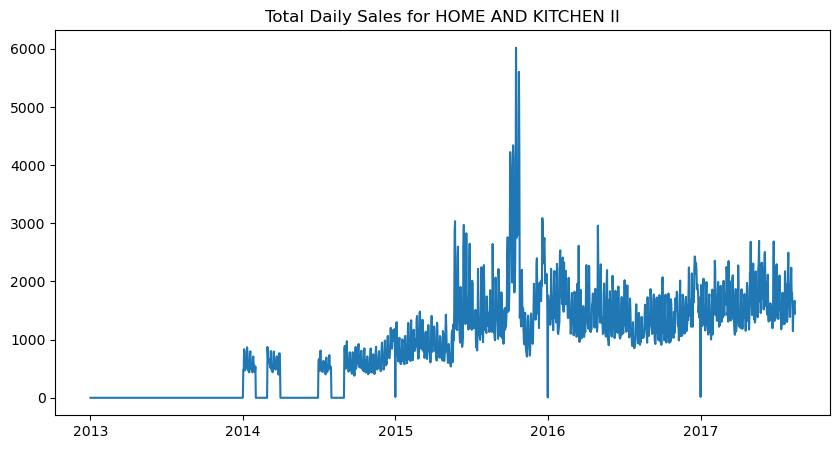

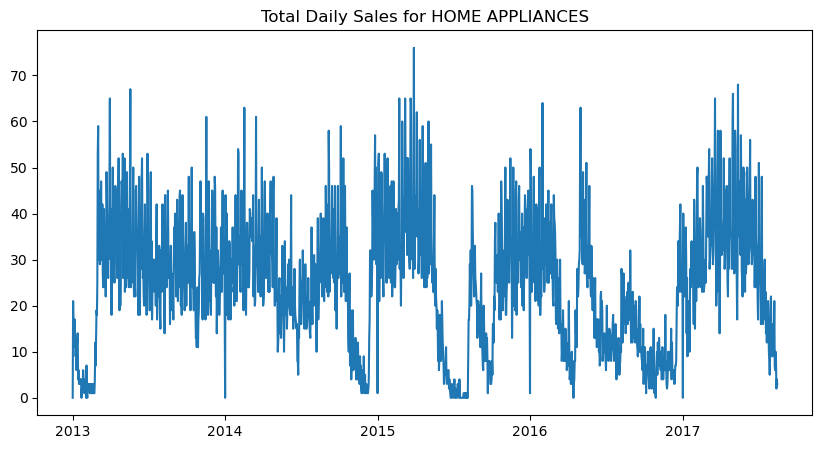

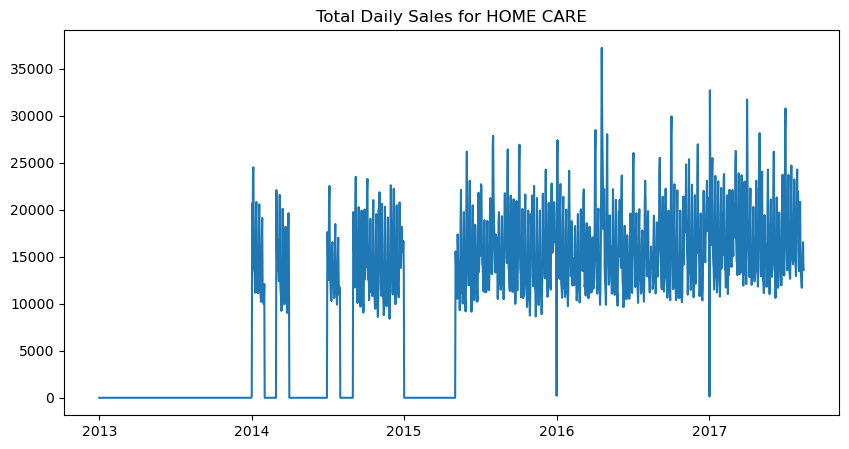

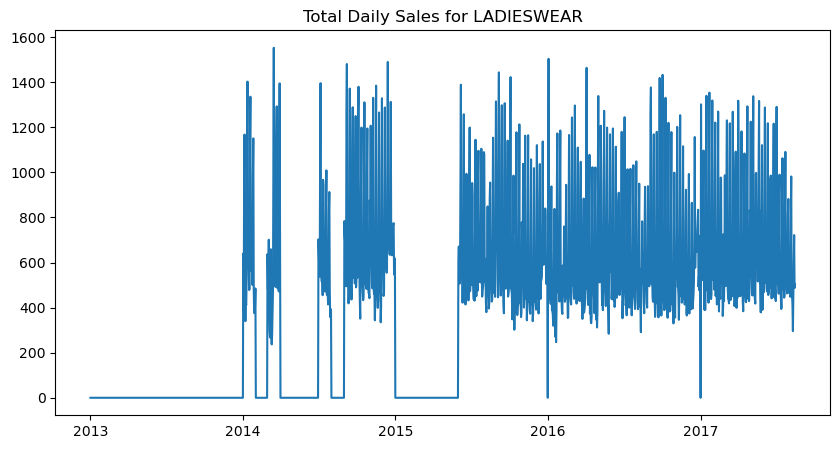

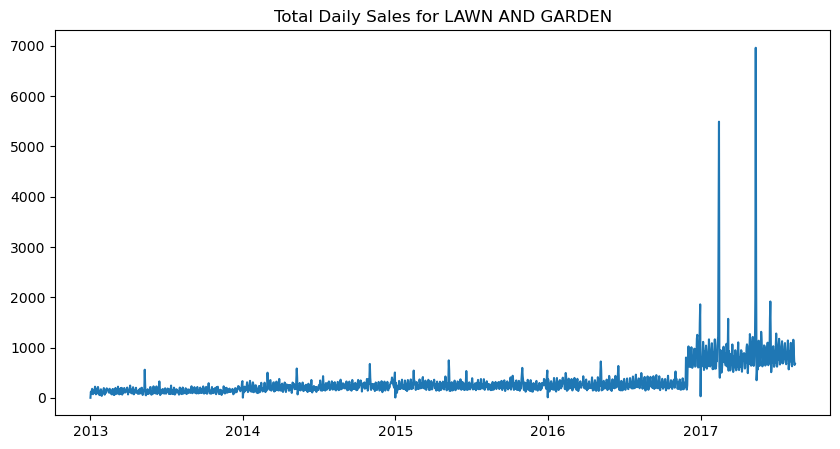

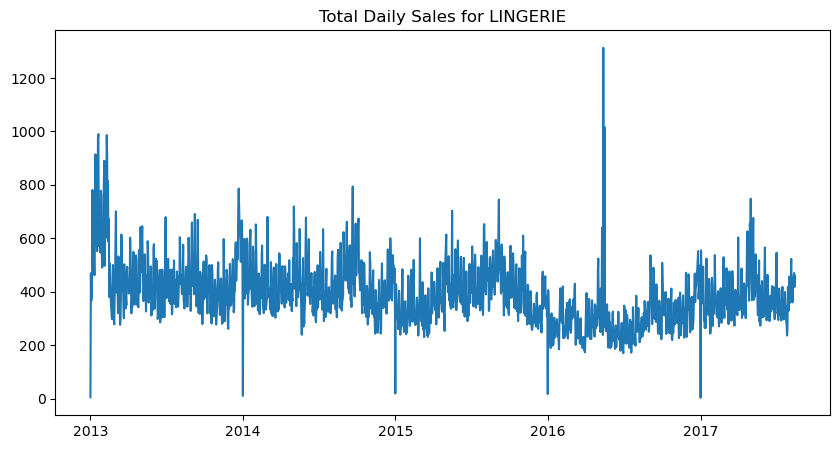

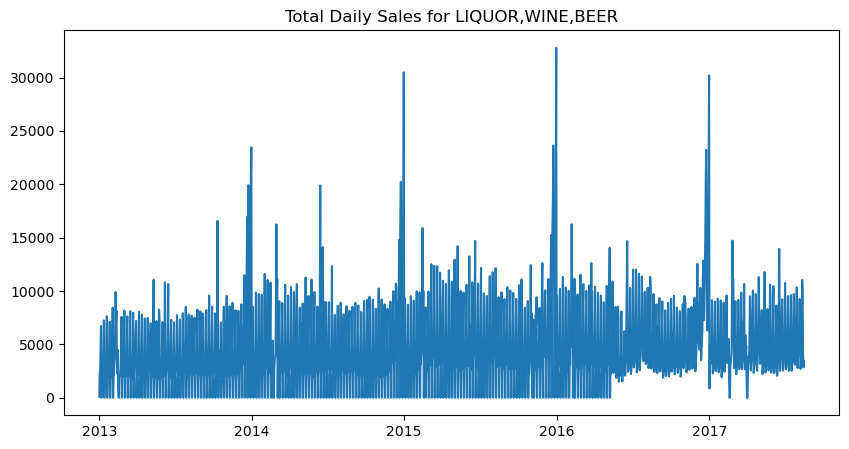

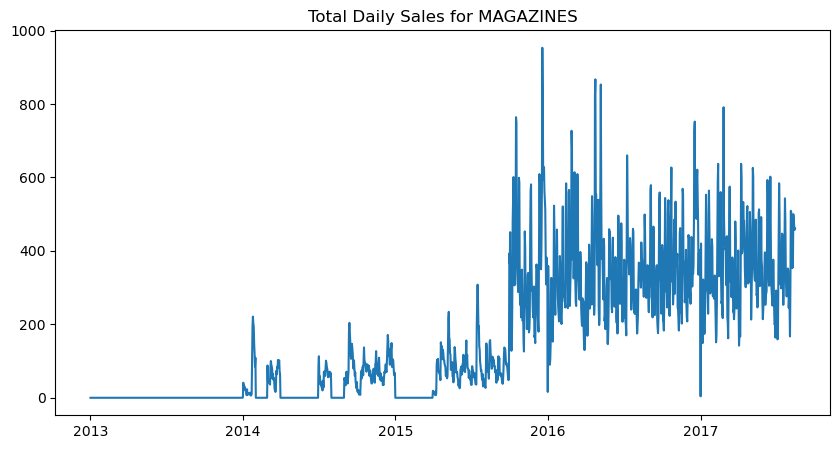

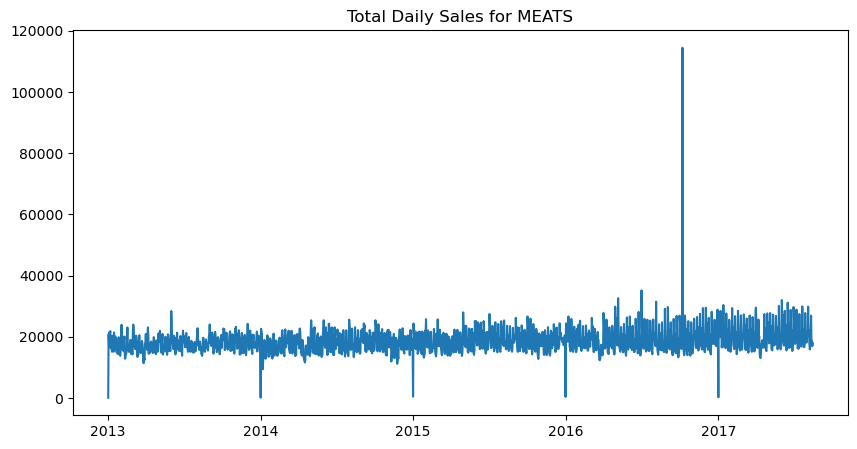

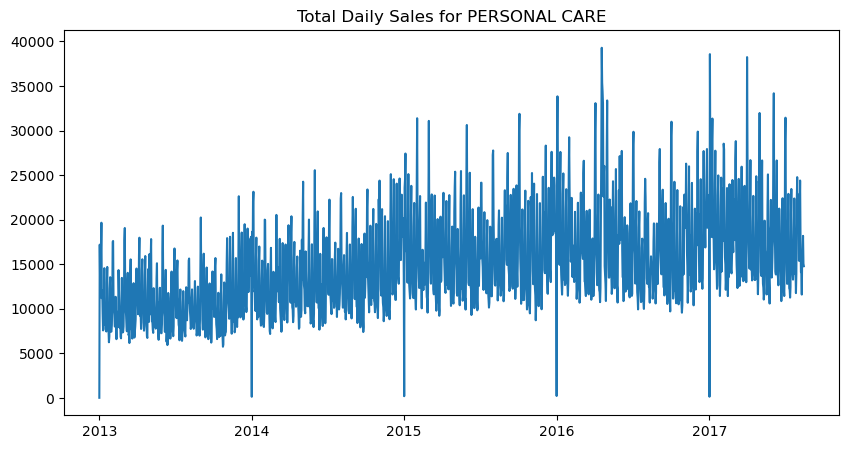

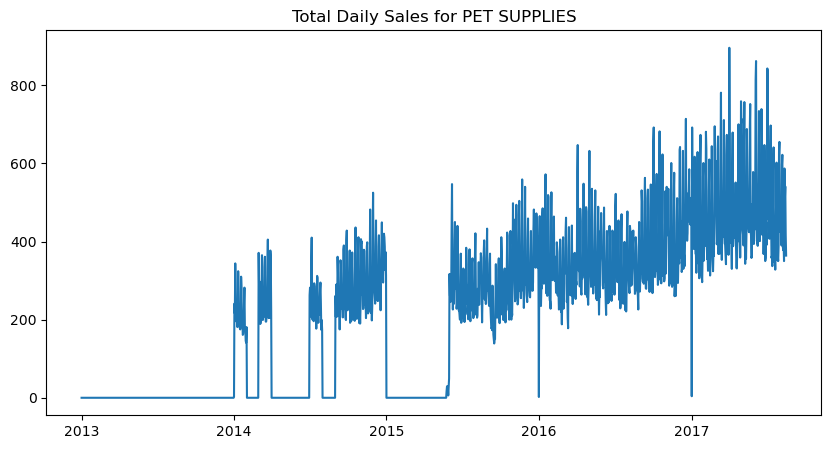

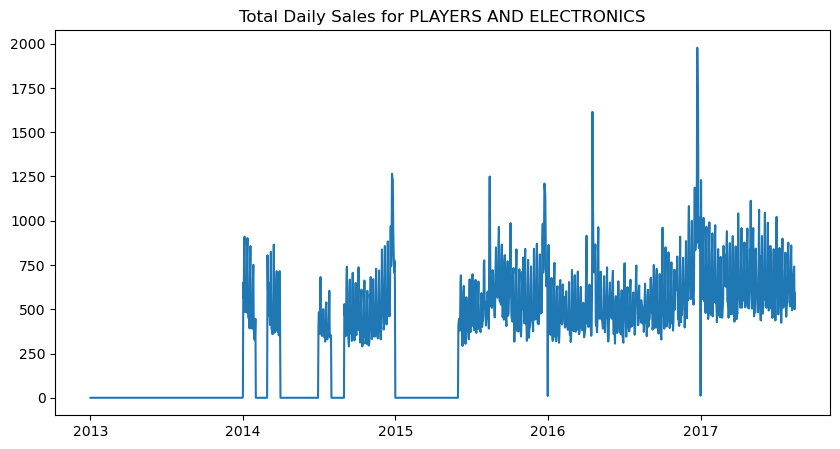

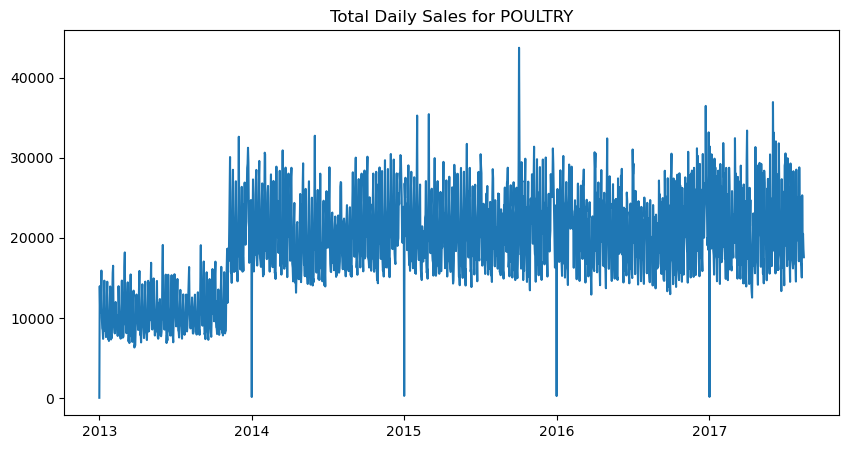

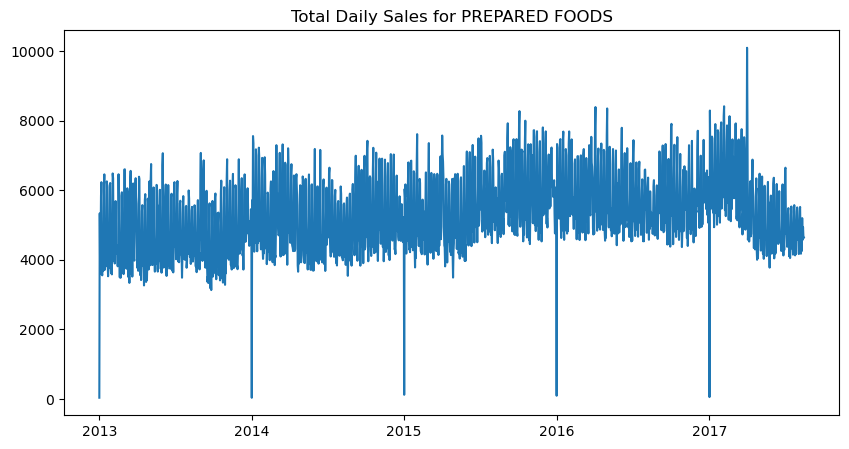

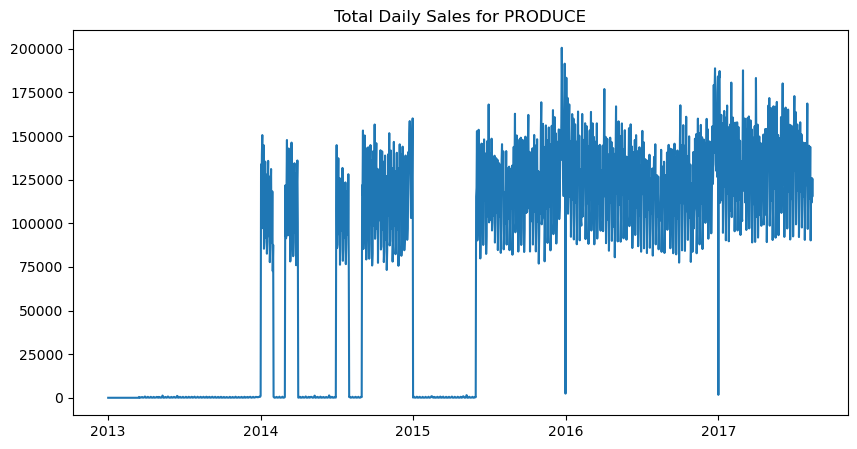

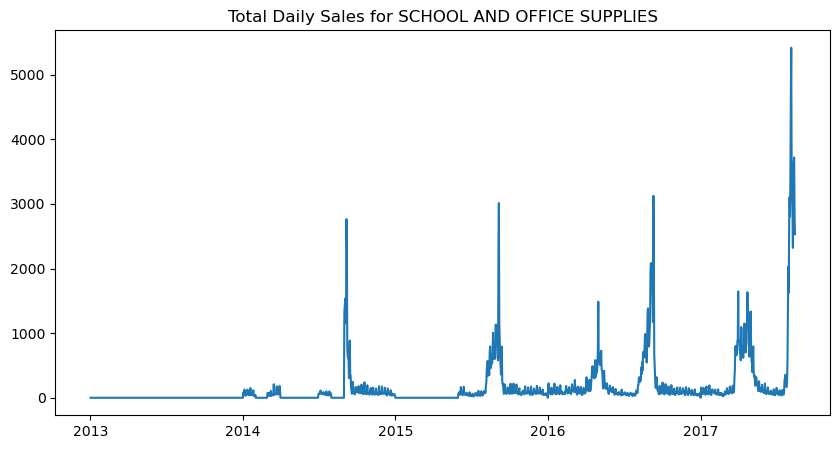

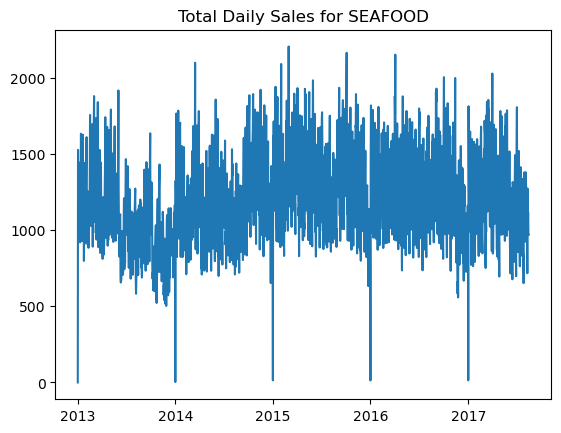

In [32]:
#Individual categories
for category in prod_sales.columns:
    plt.gcf().set_size_inches(10, 5)
    plt.figure()
    plt.title(f'Total Daily Sales for {category}')
    plt.plot(prod_sales.index, prod_sales[category])  


#### Category Percentile-Grouping
We would like to group the categories by their volume sales metrics percentile-wise to visualize the forecasted sales distributions on similar scales. This is for better assessment of our time series modeling due to seasonality. We can then identify categories with high metrics as having more data for a more robust forecast and better prediction, exploring them first.

We chose to resample, aggregating by Months, and also find the mean sales per category (across the entire time). Resampling  allows for the analysis of sales trends and patterns over broader time intervals, which can be beneficial for understanding long-term fluctuations and seasonality. We will use daily AVG sales across time for relative comparisons between categories, when grouping categories by percentiles.

In [33]:
"""
Grouping Categories by Percentile (Average Sales Across Entire Time)
"""
#Avg Sales of Each column Across Entire Time
avg_daily_sales = prod_sales.apply(np.mean, axis = 0)
print("Avg Sales Across Time: \n", avg_daily_sales)

# Calculate quartiles (25th, 50th, 75th percentiles) of avg sales for each category
#Returns Series
# low,mid,high = avg_prod_sales_pivot_m.quantile([0.25, 0.50, 0.75])                                     
low,mid= np.percentile(avg_daily_sales,[33,66])

print("Sales Percentiles:")
print("{percent} \n".format(percent = [low,mid]))


Avg Sales Across Time: 
 family
AUTOMOTIVE                       329.466746
BABY CARE                          5.968527
BEAUTY                           200.649050
BEVERAGES                     128832.830166
BOOKS                              3.823040
BREAD/BAKERY                   25020.157706
CELEBRATION                      452.005344
CLEANING                       57910.504157
DAIRY                          38294.364014
DELI                           14317.293628
EGGS                            9256.707838
FROZEN FOODS                    8357.415511
GROCERY I                     203956.493400
GROCERY II                      1165.538599
HARDWARE                          61.442993
HOME AND KITCHEN I              1105.398456
HOME AND KITCHEN II              903.010689
HOME APPLIANCES                   24.703682
HOME CARE                       9514.693587
LADIESWEAR                       386.673990
LAWN AND GARDEN                  325.915677
LINGERIE                         387.834917


In [34]:
#Get categories belonging to specific quantiles
low_cat = avg_daily_sales[avg_daily_sales <= low].index
mid_cat = avg_daily_sales[ (avg_daily_sales.values >low) & (avg_daily_sales.values <= mid)].index
high_cat = avg_daily_sales[avg_daily_sales.values > mid].index

print(f"The low quartile categories are: \n {low_cat} \n")
print(f"The low quartile categories are: \n {mid_cat} \n")
print(f"The low quartile categories are: \n {high_cat} \n")

The low quartile categories are: 
 Index(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BOOKS', 'HARDWARE',
       'HOME APPLIANCES', 'LAWN AND GARDEN', 'MAGAZINES', 'PET SUPPLIES',
       'PLAYERS AND ELECTRONICS', 'SCHOOL AND OFFICE SUPPLIES'],
      dtype='object', name='family') 

The low quartile categories are: 
 Index(['CELEBRATION', 'EGGS', 'FROZEN FOODS', 'GROCERY II',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'LADIESWEAR', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'PREPARED FOODS', 'SEAFOOD'],
      dtype='object', name='family') 

The low quartile categories are: 
 Index(['BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'GROCERY I',
       'HOME CARE', 'MEATS', 'PERSONAL CARE', 'POULTRY', 'PRODUCE'],
      dtype='object', name='family') 



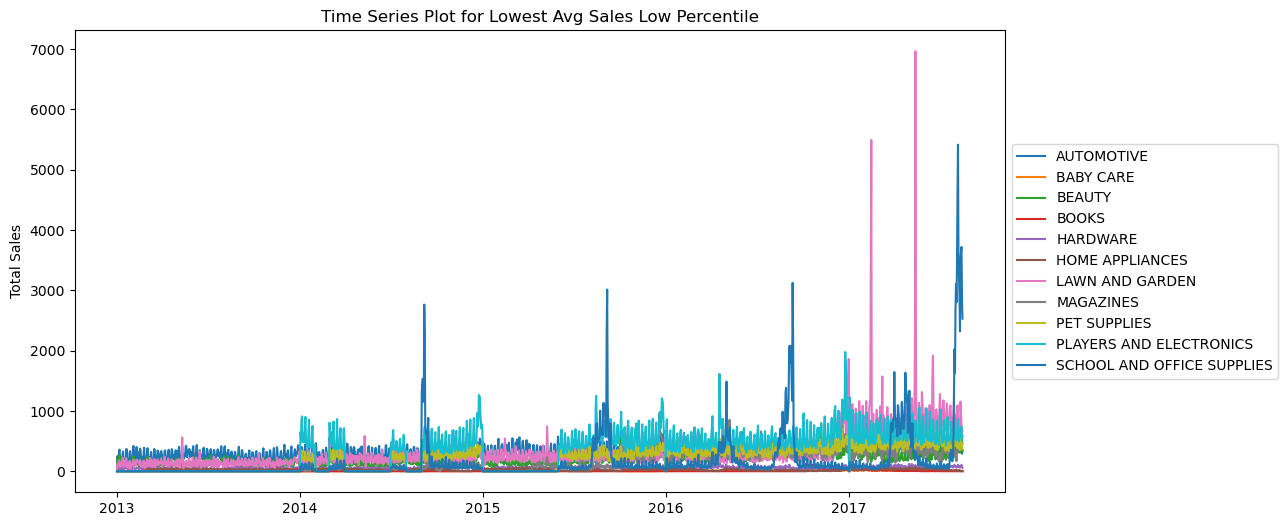

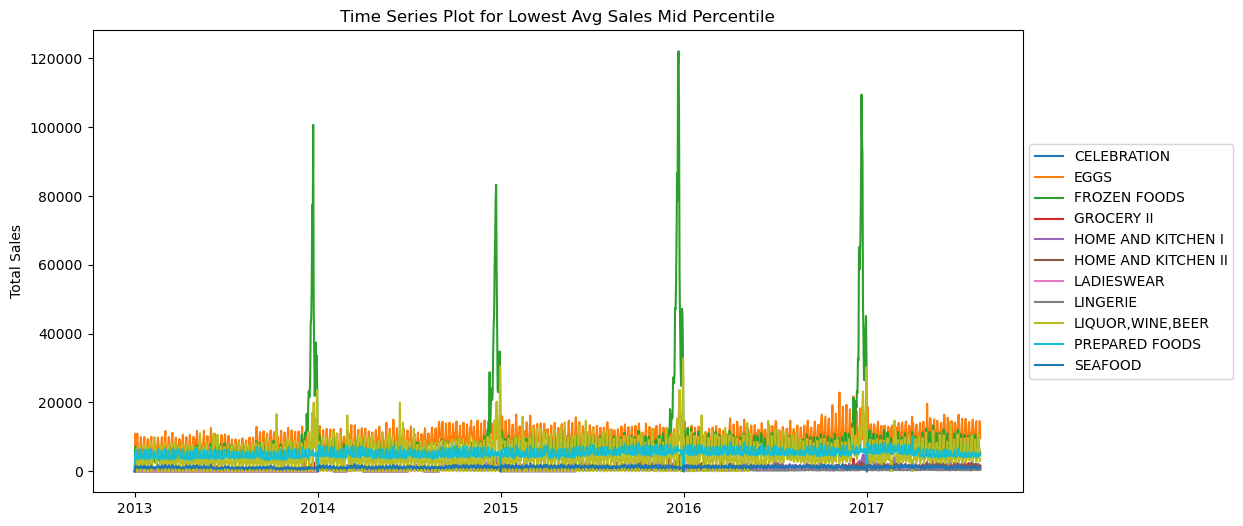

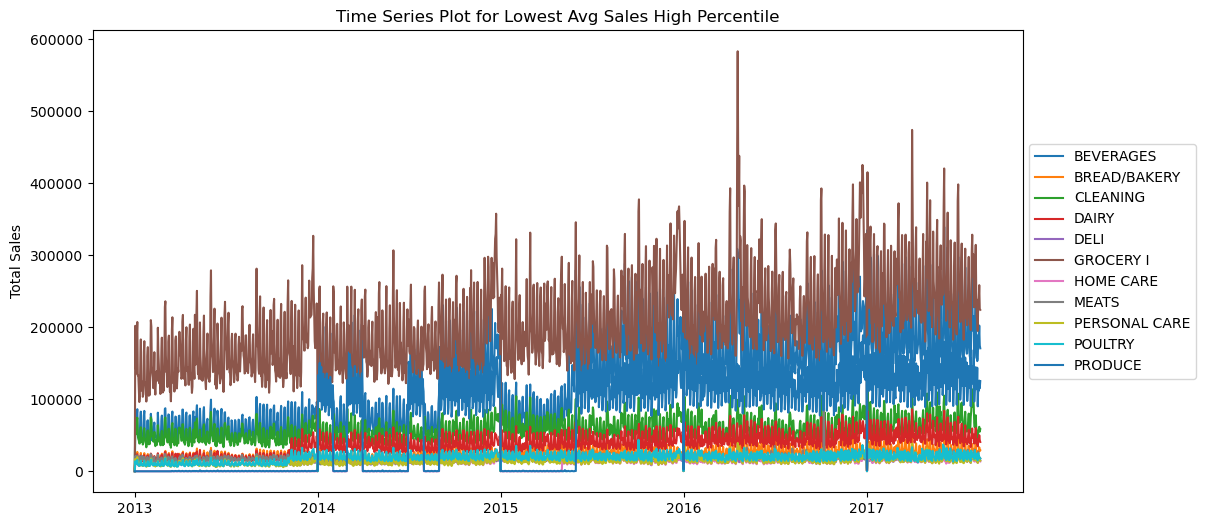

In [35]:
""""
Plot categories in Same Percentile
by Total Sales 
"""
percent_col = [low_cat, mid_cat, high_cat]
percentiles = ["Low", "Mid", "High"]

for percent_col, percentile in zip(percent_col, percentiles): #Want them to correlate to other in the same position, can't use dict
        plt.gcf().set_size_inches(12, 6)
        plt.plot(prod_sales[percent_col])
        plt.ylabel('Total Sales')
        plt.title(f'Time Series Plot for Lowest Avg Sales {percentile} Percentile')
        plt.legend(percent_col, loc='center left', bbox_to_anchor=(1, 0.5))

        plt.show()

### ML Method: Prophet

We would use one of the high percentile categories and predict next 30 days with our designed forecasting model using Facebooks's PROPHET library.
    https://facebook.github.io/prophet/ is the documentation. We will use the https://pypi.org/project/holidays/ python library to get the hoiday data.

In [36]:
feature = 'PRODUCE'
prediction_days = 30

produce_sales_df = prod_sales['PRODUCE'].reset_index()
produce_sales_df

,date,PRODUCE
0,2013-01-01,0.00000
1,2013-01-02,0.00000
2,2013-01-03,0.00000
3,2013-01-04,0.00000
4,2013-01-05,0.00000
...,...,...
1679,2017-08-11,118738.14300
1680,2017-08-12,111788.35090
1681,2017-08-13,125923.80240
1682,2017-08-14,115257.59598


Given examples from the PROPHET documentation that there's an option to address holiday effects as part of seasonality, it is noted that Ecuardorian holidays have to be used to reflect the dataset. This then leads to the need of the columns holiday and date. With the specific python library *holiday* which can be customized to desired country, and will result in the name of the holiday as well as the date, we will use a window of 2 days before and after the holiday, accounting for seasonality. Holidays can have significant impact on affecting the performance of our model, as well as other parameters/factors in our PROPHET Model.

The created df will be utilized later during OPTIMIZATION/HYPERPARAMETER Tuning of our model.


In [37]:
from datetime import date
import holidays
"""
Create holiday data: 
Use the holiday library to confirm which dates are holidays
    superbowls = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2010-02-07', '2014-02-02', '2016-02-07']),
    'lower_window': 0,
    'upper_window': 1,
    })
"""
#Initalize holiday df
holiday_df = pd.DataFrame()

#For all days between 2015-2018, create holiday with specificed columns, concatenate
for date_, holiday_name in sorted(holidays.EC(years=[2015, 2016,2017, 2018]).items()): # https://python-holidays.readthedocs.io/en/latest/examples.html  
    # print(date_, holiday_name)
    one_holiday = pd.DataFrame([{
    'holiday': holiday_name,
    'ds': pd.to_datetime(date_),
    'lower_window': -2,
    'upper_window': 2,
    }])
    holiday_df = pd.concat([holiday_df,one_holiday]).sort_values('ds')
holiday_df.head()

,holiday,ds,lower_window,upper_window
0,Año Nuevo,2015-01-01,-2,2
0,Carnaval,2015-02-16,-2,2
0,Carnaval,2015-02-17,-2,2
0,Viernes Santo,2015-04-03,-2,2
0,Día del Trabajo,2015-05-01,-2,2



For the math behind PROPHET, it uses a decomposable timeseries model with many components — such as trend, seasonality and holidays, where all time series is a regression model (tests correlation between dependent and independent) and built on the Fourier series-a math principle stating that the lines/trends in time series is composed of a sines and cosines.


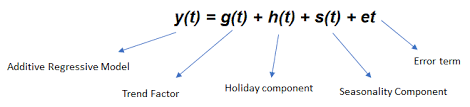

Prophet(growth='linear', changepoint_range = changepoint_range, 
       yearly_seasonality = True, weekly_seasonality = True, 
       daily_seasonality = False, seasonality_mode='multiplicative', holidays=holiday) 


In [38]:
"""
Forecasting Known Sales Period, 
Backtracking to check Prediction Robustness
W/ Historical Data

FIX YHAT ERROR
"""
from datetime import date
from prophet import Prophet

#Make Future Dataframe
forecast_date =date(2017,7,1) #2017-08-15 --> forecasting on that day forward
future_dates = pd.date_range(forecast_date, periods=30, freq='D')[0:]
future_df = pd.DataFrame({'ds': future_dates}).sort_values(by=['ds'])

#Prepare Historical Data --> ds, y columns
train_set_df = produce_sales_df[ (produce_sales_df['date'] < '2017-07-01') ]
train_set_df= train_set_df.rename(columns={'PRODUCE': 'y', 'date': 'ds'})

#Fit PROPHET Model with Historical Data
prophet_model = Prophet()  # Specify optimization algorithm, seasonality heavily affects model 
prophet_model.fit(train_set_df)

#Predict with model
forecast_df = prophet_model.predict(future_df)
forecast_df.head()


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


INFO:cmdstanpy:finish chain 1


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2017-07-01,137657.008234,106720.985036,197342.433449,137657.008234,137657.008234,12069.320624,12069.320624,12069.320624,6434.152024,6434.152024,6434.152024,5635.168600,5635.168600,5635.168600,0.0,0.0,0.0,149726.328858
1,2017-07-02,137694.858438,111403.960740,205042.325224,137694.858438,137694.858438,19945.563637,19945.563637,19945.563637,13106.382889,13106.382889,13106.382889,6839.180747,6839.180747,6839.180747,0.0,0.0,0.0,157640.422075
2,2017-07-03,137732.708642,94020.266793,181756.216910,137732.708642,137732.708642,2914.371489,2914.371489,2914.371489,-5193.389563,-5193.389563,-5193.389563,8107.761052,8107.761052,8107.761052,0.0,0.0,0.0,140647.080132
3,2017-07-04,137770.558847,99476.382276,186363.504606,137770.558847,137770.558847,6422.466454,6422.466454,6422.466454,-3004.375545,-3004.375545,-3004.375545,9426.841999,9426.841999,9426.841999,0.0,0.0,0.0,144193.025301
4,2017-07-05,137808.409051,119057.921317,210727.565926,137808.409051,137808.409051,27504.150249,27504.150249,27504.150249,16724.136534,16724.136534,16724.136534,10780.013714,10780.013714,10780.013714,0.0,0.0,0.0,165312.559299


In [39]:
"""
Create DataFrame with ds, yhat, ytrue
"""
produce_sales_copy = produce_sales_df.copy()

#df of Sales data not part of forecasted time
actual_values = produce_sales_copy[(produce_sales_copy['date'] >= '2017-07-01') 
                                   & (produce_sales_copy['date'] <= '2017-07-30')][['date','PRODUCE']]
actual_values = actual_values.rename(columns = {'PRODUCE': 'ytrue'}).reset_index(drop=True)

predicted_values = forecast_df.copy()

# print(len(actual_values), len(predicted_values) ) #Check if they have the same prediction dates
# actual_values.reset_index(drop=True).compare(predicted_values)
# print(actual_values.reset_index(drop=True))

#Merge actual and predicted values (forecast_df) on date
predicted_df = actual_values.merge(predicted_values, how = 'inner', left_on = 'date', right_on = 'ds' )
predicted_df = predicted_df.drop(columns=['date'])
predicted_df = predicted_df.reindex(columns=['ds', 'ytrue', 'yhat'])
# actual_values
# forecast_df
predicted_df.head()

,ds,ytrue,yhat
0,2017-07-01,155487.63090,149726.328858
1,2017-07-02,172890.13860,157640.422075
2,2017-07-03,130389.19902,140647.080132
3,2017-07-04,131534.54802,144193.025301
4,2017-07-05,163804.33003,165312.559299


In [40]:
"Evaluate and Calculate Performance Metrics (RSME)"
rmse = np.sqrt(np.mean((actual_values['ytrue'] - predicted_values['yhat']) ** 2))
print("Root Mean Squared Error (RMSE): $", rmse)

Root Mean Squared Error (RMSE): $ 28688.165613583275


Since our RSME is just in the ten-thousands and our total sales are in the hundred thousands, we can temporarily note that it is a 'good' RSME score. We will still need to perform cross validation, as well as comprehensively get all the relevant performance metrics.

### Cross-Validation and HyperParameter Tuning
Cross Validation measures forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point over the entire time frame repeatedly. We can then compare the forecasted values to the actual values.  

Perform time-series cross-validation first to assess the effectiveness of the model,to normalize our predictions due to inconsistency of cutoff days or noise, for more accurate metrics and more robust testing, decreasing overfitting and increasing accuracy (100-MAPE).
Then, perform hyperparameter tuning to further optimize model, including cross-validation, with performance statistics such as Mean Absolute Percent Error (MAPE). https://facebook.github.io/prophet/docs/diagnostics.html 


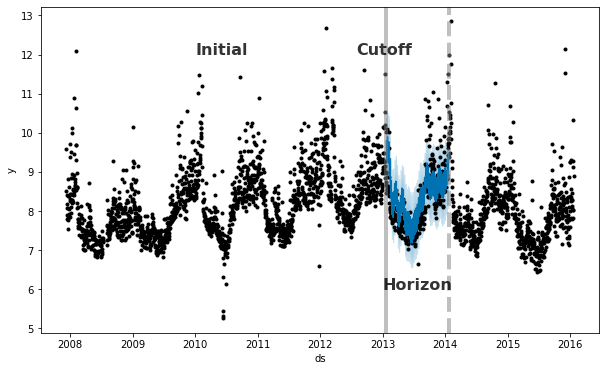

We would choose an 'inital' period in which the model is trained on up to that point to fit the model and predict error comparing true vs. predicted values over a specified number of days (MAPE) until our cutoff date, then we would perform the same 'sliding' window calculations.

Example would be our inital period specified is 2014/7/1, and we would forecast/predict the values from the observed values from the cutoff + horizon date (until 2015/7/1).

Note: We generally exclude holidays from the training data used in each fold of the cross-validation process. Including holidays in the training data for each fold could lead to data leakage and biased evaluation of the model's performance.

In [41]:
""" 
Cross Validation Without Hyperparameter Tuning
"""
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation, where we predict next 30 days and assess forecast error
prophet_model = Prophet()
prophet_model.fit(train_set_df)

df_cv = cross_validation(prophet_model, initial='700 days', period='30 days', horizon = '30 days');

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:cmdstanpy:start chain 1


INFO:cmdstanpy:finish chain 1
INFO:prophet:Making 31 forecasts with cutoffs between 2014-12-13 00:00:00 and 2017-05-31 00:00:00
  0%|          | 0/31 [00:00<?, ?it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
  3%|▎         | 1/31 [00:00<00:10,  2.88it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
  6%|▋         | 2/31 [00:00<00:09,  3.11it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
 10%|▉         | 3/31 [00:01<00:10,  2.65it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
 13%|█▎        | 4/31 [00:01<00:13,  2.00it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
 16%|█▌        | 5/31 [00:02<00:12,  2.12it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
 19%|█▉        | 6/31 [00:02<00:10,  2.35it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
 23%|██▎       | 7/31 [00:02<00:09,  2.45it/s]INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1
 26%|██▌       | 8/31 [00:03<00:09,  2.4

In [42]:
# Calculate performance metrics
df_metrics = performance_metrics(df_cv)
df_metrics

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,1.850710e+09,43019.879407,32194.644818,89.338679,0.212291,0.536250,0.784712
1,4 days,1.916420e+09,43776.936834,32883.522249,75.408285,0.208119,0.540285,0.763324
2,5 days,1.891424e+09,43490.508785,32525.751795,64.205259,0.208119,0.540402,0.752454
3,6 days,1.964271e+09,44320.093156,31725.471055,51.773623,0.208119,0.531610,0.741935
4,7 days,1.921256e+09,43832.132189,31142.238226,80.479128,0.174127,0.531333,0.763675
5,8 days,1.946860e+09,44123.232566,32811.489163,106.265124,0.223676,0.549592,0.785414
6,9 days,2.105239e+09,45882.880110,34528.922112,121.719875,0.240387,0.561509,0.795582
7,10 days,2.195422e+09,46855.328050,35241.151575,105.035022,0.228422,0.563827,0.762973
8,11 days,2.245491e+09,47386.610729,35787.642068,85.060439,0.220731,0.564438,0.730715
9,12 days,2.150841e+09,46377.158898,35422.487524,82.362853,0.209187,0.567005,0.706522


MAPE is interpreted percentage-wise, so 0.01 is 1%v MAPE or 91% accuracy.

In [43]:
    """
    Make Model Evaluation and Pipeline more optimized
    By Creating Functions for PROPHET model for Multiple ategories
    """

'\nMake Model Evaluation and Pipeline more optimized\nBy Creating Functions for PROPHET model for Multiple ategories\n'